# Dueling DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(4,)
Action space Discrete(2)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        
        # decompose state & action values
        self.state_layer = nn.Linear(fc2_units, 1)
        self.advantage_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        
        state_value = self.state_layer(state).expand(state.size(0), self.action_size)
        advantage_value = self.advantage_layer(state)
        
        Qsa = state_value + advantage_value - advantage_value.mean(1).unsqueeze(1).expand(state.size(0), self.action_size)
        
        return Qsa        

## Set Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf) Agent

In [11]:
class Dueling_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = Dueling_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 100.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/Dueling_DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 17.69
Episode: 200, Average Score: 13.56
Episode: 300, Average Score: 11.57
Episode: 400, Average Score: 12.13
Episode: 500, Average Score: 15.21
Episode: 600, Average Score: 55.73
Episode: 651, Average Score: 100.34
Environment solved in 551 episodes! Average Score: 100.34
Episode: 652, Average Score: 101.62
Environment solved in 552 episodes! Average Score: 101.62
Episode: 653, Average Score: 102.55
Environment solved in 553 episodes! Average Score: 102.55
Episode: 654, Average Score: 103.48
Environment solved in 554 episodes! Average Score: 103.48
Episode: 655, Average Score: 104.67
Environment solved in 555 episodes! Average Score: 104.67
Episode: 656, Average Score: 105.63
Environment solved in 556 episodes! Average Score: 105.63
Episode: 657, Average Score: 106.83
Environment solved in 557 episodes! Average Score: 106.83
Episode: 658, Average Score: 107.83
Environment solved in 558 episodes! Average Score: 107.83
Episode: 659, Average Score: 108.71
En

Episode: 737, Average Score: 160.78
Environment solved in 637 episodes! Average Score: 160.78
Episode: 738, Average Score: 161.32
Environment solved in 638 episodes! Average Score: 161.32
Episode: 739, Average Score: 162.02
Environment solved in 639 episodes! Average Score: 162.02
Episode: 740, Average Score: 162.78
Environment solved in 640 episodes! Average Score: 162.78
Episode: 741, Average Score: 163.98
Environment solved in 641 episodes! Average Score: 163.98
Episode: 742, Average Score: 163.27
Environment solved in 642 episodes! Average Score: 163.27
Episode: 743, Average Score: 163.70
Environment solved in 643 episodes! Average Score: 163.70
Episode: 744, Average Score: 164.69
Environment solved in 644 episodes! Average Score: 164.69
Episode: 745, Average Score: 165.24
Environment solved in 645 episodes! Average Score: 165.24
Episode: 746, Average Score: 165.61
Environment solved in 646 episodes! Average Score: 165.61
Episode: 747, Average Score: 166.18
Environment solved in 64

Episode: 826, Average Score: 186.31
Environment solved in 726 episodes! Average Score: 186.31
Episode: 827, Average Score: 186.49
Environment solved in 727 episodes! Average Score: 186.49
Episode: 828, Average Score: 186.10
Environment solved in 728 episodes! Average Score: 186.10
Episode: 829, Average Score: 185.77
Environment solved in 729 episodes! Average Score: 185.77
Episode: 830, Average Score: 186.10
Environment solved in 730 episodes! Average Score: 186.10
Episode: 831, Average Score: 185.73
Environment solved in 731 episodes! Average Score: 185.73
Episode: 832, Average Score: 186.00
Environment solved in 732 episodes! Average Score: 186.00
Episode: 833, Average Score: 185.84
Environment solved in 733 episodes! Average Score: 185.84
Episode: 834, Average Score: 185.34
Environment solved in 734 episodes! Average Score: 185.34
Episode: 835, Average Score: 184.90
Environment solved in 735 episodes! Average Score: 184.90
Episode: 836, Average Score: 185.22
Environment solved in 73

Episode: 914, Average Score: 174.12
Environment solved in 814 episodes! Average Score: 174.12
Episode: 915, Average Score: 174.12
Environment solved in 815 episodes! Average Score: 174.12
Episode: 916, Average Score: 174.23
Environment solved in 816 episodes! Average Score: 174.23
Episode: 917, Average Score: 174.29
Environment solved in 817 episodes! Average Score: 174.29
Episode: 918, Average Score: 173.71
Environment solved in 818 episodes! Average Score: 173.71
Episode: 919, Average Score: 173.34
Environment solved in 819 episodes! Average Score: 173.34
Episode: 920, Average Score: 173.45
Environment solved in 820 episodes! Average Score: 173.45
Episode: 921, Average Score: 173.52
Environment solved in 821 episodes! Average Score: 173.52
Episode: 922, Average Score: 173.35
Environment solved in 822 episodes! Average Score: 173.35
Episode: 923, Average Score: 173.68
Environment solved in 823 episodes! Average Score: 173.68
Episode: 924, Average Score: 173.51
Environment solved in 82

## Evaluate The Agent

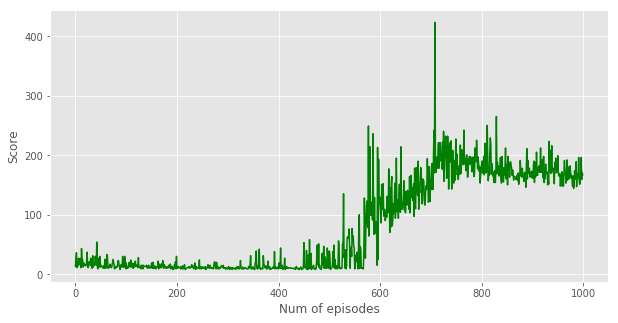

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/Dueling_DQN_{ENV_NAME}.pth'));

In [18]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(200):
        
        env.render() # render the screen
        
        action = policy.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

---